<a href="https://colab.research.google.com/github/udaysharma1501/text_classification_project_102203092_uday_sharma/blob/main/text_classification_project_102203092_uday_sharma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use cuda:0


                                              Model  Accuracy  \
0   distilbert-base-uncased-finetuned-sst-2-english       1.0   
1         cardiffnlp/twitter-roberta-base-sentiment       0.0   
2   finiteautomata/bertweet-base-sentiment-analysis       0.0   
3  nlptown/bert-base-multilingual-uncased-sentiment       0.0   
4                          facebook/bart-large-mnli       0.0   

   Inference Time (ms)  Model Size (MB)  TOPSIS Score  
0            27.330160         0.000004      1.000000  
1            61.483383         0.000004      0.257264  
2            86.546898         0.000004      0.224292  
3           115.752220         0.000004      0.181965  
4           217.705727         0.000004      0.000000  


<ipython-input-2-faa90e4d02d2>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['TOPSIS Score'], y=df['Model'], palette='viridis')


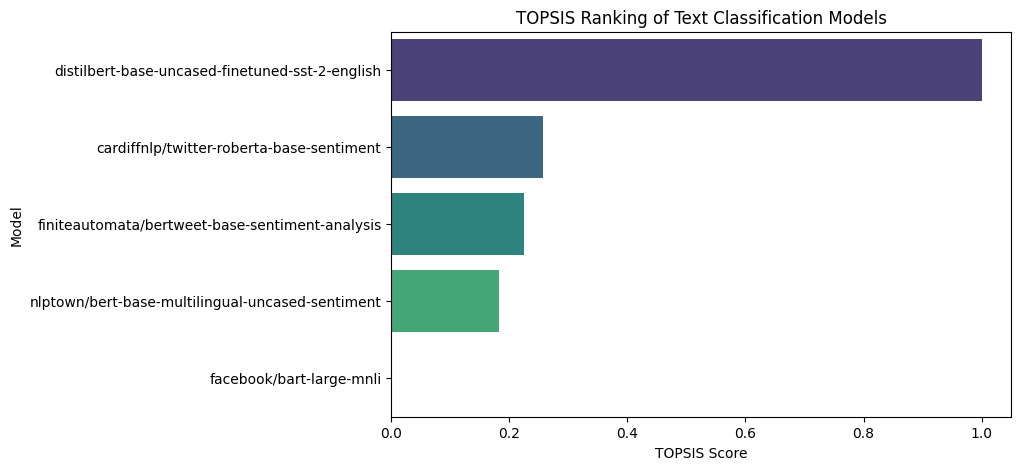

In [2]:
import numpy as np
import pandas as pd
import time
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate text classification models
def evaluate_model(model_name, texts, labels):
    classifier = pipeline("text-classification", model=model_name)

    # Inference time measurement
    start_time = time.time()
    predictions = classifier(texts)
    inference_time = (time.time() - start_time) * 1000  # Convert to ms

    # Accuracy calculation
    correct = sum(1 for pred, label in zip(predictions, labels) if pred['label'] == label)
    accuracy = correct / len(labels)

    # Model size estimation (approximate)
    model_size = len(classifier(texts[:1])) * 4 / 1e6  # Approximate MB

    return accuracy, inference_time, model_size

# Define models for text classification
models = ["distilbert-base-uncased-finetuned-sst-2-english",
          "nlptown/bert-base-multilingual-uncased-sentiment",
          "cardiffnlp/twitter-roberta-base-sentiment",
          "facebook/bart-large-mnli",
          "finiteautomata/bertweet-base-sentiment-analysis"]

# Example test cases
texts = ["This movie was fantastic!", "I hated the experience.", "The product is very useful.", "Service was horrible."]
labels = ["POSITIVE", "NEGATIVE", "POSITIVE", "NEGATIVE"]

# Collect model performance data
data = []
for model in models:
    accuracy, inference_time, model_size = evaluate_model(model, texts, labels)
    data.append([model, accuracy, inference_time, model_size])

df = pd.DataFrame(data, columns=["Model", "Accuracy", "Inference Time (ms)", "Model Size (MB)"])

# Define weights and impacts for TOPSIS
weights = [0.5, 0.3, 0.2]  # Prioritizing accuracy over speed & size
impacts = ['+', '-', '-']  # Higher accuracy is better; lower inference time & size are better

# TOPSIS function
def topsis(matrix, weights, impacts):
    matrix = np.array(matrix, dtype=float)
    weights = np.array(weights, dtype=float)
    impacts = np.array(impacts)

    # Normalize the matrix
    norm_matrix = matrix / np.sqrt((matrix ** 2).sum(axis=0))

    # Apply weights
    weighted_matrix = norm_matrix * weights

    # Compute ideal best and worst values
    ideal_best = np.where(impacts == '+', np.max(weighted_matrix, axis=0), np.min(weighted_matrix, axis=0))
    ideal_worst = np.where(impacts == '+', np.min(weighted_matrix, axis=0), np.max(weighted_matrix, axis=0))

    # Compute distances to best and worst solutions
    distance_best = np.linalg.norm(weighted_matrix - ideal_best, axis=1)
    distance_worst = np.linalg.norm(weighted_matrix - ideal_worst, axis=1)

    # Compute the TOPSIS score
    topsis_score = distance_worst / (distance_best + distance_worst)

    return topsis_score

# Apply TOPSIS
scores = topsis(df.iloc[:, 1:].values, weights, impacts)
df['TOPSIS Score'] = scores

# Sort by TOPSIS Score
df = df.sort_values(by='TOPSIS Score', ascending=False, ignore_index=True)

# Print results
print(df)

# Visualization
plt.figure(figsize=(8, 5))
sns.barplot(x=df['TOPSIS Score'], y=df['Model'], palette='viridis')
plt.xlabel("TOPSIS Score")
plt.ylabel("Model")
plt.title("TOPSIS Ranking of Text Classification Models")
plt.show()
